<a href="https://colab.research.google.com/github/shivendr7/SatGAN/blob/master/EEGANtillEESN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

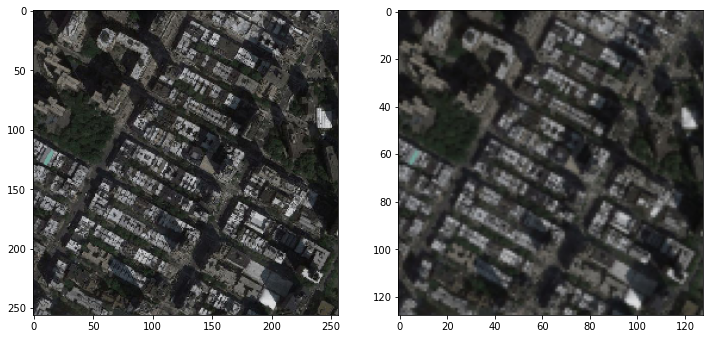

In [294]:
import os
import matplotlib.pyplot as plt
from os import listdir
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.utils import get_file
from tensorflow.io import read_file
from skimage import data, color
from skimage.transform import resize
url='http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz'
path_to_zip=get_file('maps.tar.gz', origin=url, extract=True)
inside_train=listdir('/root/.keras/datasets/maps/train')
src_list=[]
full_path='/root/.keras/datasets/maps/train/'
for filename in inside_train:
  pixels=load_img(full_path+filename, target_size=(256,512))
  pixels=img_to_array(pixels)
  src_list.append(pixels[:,:256])
src_list=np.asarray(src_list)
resized_list=[]
for i in src_list:
  image=i
  image_resized = resize(image, (image.shape[0] // 2, image.shape[1] // 2),
                        anti_aliasing=True)
  resized_list.append(image_resized)
resized_list=np.array(resized_list)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(src_list[0].astype('uint8'))
plt.subplot(1,2,2)
plt.imshow(resized_list[0].astype('uint8'))

In [295]:
resized_list=(resized_list-127.5)/127.5
src_list=(src_list-127.5)/127.5

In [296]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Concatenate, Lambda, Subtract, Add, Activation, Reshape, Multiply, Flatten, Dropout, Dense, BatchNormalization, Permute
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from tensorflow.keras.initializers import RandomNormal, Ones
import tensorflow as tf
from keras.losses import MeanSquaredError, MeanAbsolutePercentageError
import keras.backend as K
import numpy as np

In [297]:
def dense_block(in_layer):
  init=RandomNormal(stddev=0.2)
  conv1=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(in_layer)
  conv11=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv1)
  conv12=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv1)
  conv13=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv1)
  concat1=Concatenate()([conv11, conv12, conv13])
  conv201=Concatenate()([concat1, conv11])
  conv202=Concatenate()([concat1, conv12])
  conv203=Concatenate()([concat1, conv13])
  conv21i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv201)
  conv22i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv202)
  conv23i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv203)
  conv21=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv21i)
  conv22=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv22i)
  conv23=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv23i)
  concat2=Concatenate()([conv21, conv22, conv23])
  conv301=Concatenate()([concat2, conv21i])
  conv302=Concatenate()([concat2, conv22i])
  conv303=Concatenate()([concat2, conv23i])
  conv31i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv301)
  conv32i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv302)
  conv33i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv303)
  conv31=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv31i)
  conv32=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv32i)
  conv33=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv33i)
  concat3=Concatenate()([conv31, conv32, conv33])
  conv401=Concatenate()([concat3, conv31i])
  conv402=Concatenate()([concat3, conv32i])
  conv403=Concatenate()([concat3, conv33i])
  conv41i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv401)
  conv42i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv402)
  conv43i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv403)
  concat4=Concatenate()([conv41i, conv42i, conv43i])
  out_layer=Concatenate()([concat4, conv1])
  return out_layer

In [298]:
inp=Input(shape=(28,28,1))
m=Model(inputs=inp, outputs=dense_block(inp))
#plot_model(m)

In [299]:
def SubpixelConv2D(input_shape, scale=4):
    """
    Keras layer to do subpixel convolution.
    NOTE: Tensorflow backend only. Uses tf.depth_to_space
    Ref:
        [1] Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network
            Shi et Al.
            https://arxiv.org/abs/1609.05158
    :param input_shape: tensor shape, (batch, height, width, channel)
    :param scale: upsampling scale. Default=4
    :return:
    """
    # upsample using depth_to_space
    def subpixel_shape(input_shape):
        dims = [input_shape[0],
                input_shape[1] * scale,
                input_shape[2] * scale,
                int(input_shape[3] / (scale ** 2))]
        output_shape = tuple(dims)
        return output_shape

    def subpixel(x):
        return tf.nn.depth_to_space(x, scale)

    return Lambda(subpixel, output_shape=subpixel_shape, name='subpixel')

In [300]:
def build_udsn(image_shape):
  inp=Input(shape=image_shape)
  db1=dense_block(inp)
  con=Concatenate()([db1, db1])
  db2=dense_block(con)
  con=Concatenate()([db1, db2, db2])
  db3=dense_block(con)
  con=Concatenate()([db1, db2, db3, db3])
  db4=dense_block(con)
  con=Concatenate()([db1, db2, db3, db4, db4])
  db5=dense_block(con)
  con=Concatenate()([db1, db2, db3, db4, db5, db5])
  db6=dense_block(con)
  sub_net=Conv2D(filters=64, kernel_size=(4,4), padding='same', activation='relu', kernel_initializer='he_uniform')(db6)
  sub_net=Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  sub_net=Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  LR=Conv2D(filters=12, kernel_size=(3,3), padding='same')(sub_net)
  LR=LeakyReLU(alpha=0.2)(LR)
  Ibase=SubpixelConv2D(LR.shape, scale=2)(LR)
  Ibase=BatchNormalization(momentum=0.8)(Ibase)
  Ibase=Activation('tanh')(Ibase)
  model=Model(inputs=inp, outputs=Ibase)
  return model

In [301]:
udsn=build_udsn(image_shape=(128,128,3))
#plot_model(udsn)

In [302]:
#eesn essentials
def meanfilter(shape, dtype=None):   #kernel to find mean of 3-channel pixel data
  f=np.array([
              [[[.3333],
                [.3333],
                [.33333]]]
  ])
  return K.variable(f, dtype='float32')
def laplacian(shape, dtype=None):   #laplacian kernel
  f=np.array([
      [[[-1]],[[-1]],[[-1]]],
      [[[-1]],[[ 8]],[[-1]]],
      [[[-1]],[[-1]],[[-1]]]
  ])
  return K.variable(f, dtype='float32')
def channel_thrice(shape, dtype=None):   #kernel to triplicate the single channel data
  f=np.array([
              [[[1, 1, 1]]]   #3 for three layers of filters
  ])
  return K.variable(f, dtype='float32')

In [303]:
def build_eesn(Ibase_shape):
  inp=Input(shape=(Ibase_shape))
  bw=Conv2D(filters=1, kernel_size=(1,1), padding='same', kernel_initializer=meanfilter, trainable=False)(inp)  #no change recommended   
  Iedge=Conv2D(filters=1, kernel_size=(3,3), padding='same', kernel_initializer=laplacian, trainable=False)(bw)     #no change recommended
  Itrip=Conv2D(filters=3, kernel_size=(1,1), padding='same', kernel_initializer=channel_thrice, trainable=False)(Iedge)   #no change recommended
  
  sub=Subtract()([inp, Itrip])
  ee=Conv2D(filters=32, kernel_size=(3,3), padding='same', strides=(2,2))(Iedge)
  ee=Conv2D(filters=64, kernel_size=(3,3), padding='same')(ee)
  ee=Conv2D(filters=16, kernel_size=(1,1), padding='same')(ee)
  
  #dense net
  db=dense_block(ee)
  db=dense_block(db)
  db=dense_block(db)
  db=Conv2D(16, kernel_size=(3,3), padding='same')(db)

  #mask branch
  mb=Conv2D(filters=16, kernel_size=(3,3), padding='same')(ee)
  mb=LeakyReLU(alpha=0.2)(mb)
  mb=Conv2D(filters=32, kernel_size=(3,3), padding='same')(mb)
  mb=LeakyReLU(alpha=0.2)(mb)
  mb=Conv2D(filters=16, kernel_size=(3,3), padding='same')(mb)
  mb=LeakyReLU(alpha=0.2)(mb)
  mb=Activation('sigmoid')(mb)

  #transpose=Permute((2,1,3), input_shape=db.shape)(db)
  product=Multiply()([db, mb])  #multiplies element wise
  #con=Concatenate()([mb, db])
  #transpose2=Permute((2,1,3), input_shape=product.shape)(product)
  sub_net=Conv2D(filters=64, kernel_size=(4,4), padding='same', activation='relu', kernel_initializer='he_uniform')(product)
  sub_net=Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  sub_net=Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  ee=Conv2D(4, kernel_size=(3,3), padding='same')(sub_net)
  Istedge=SubpixelConv2D(ee.shape, scale=2)(ee)
  #Istedge=Conv2D(1, kernel_size=(3,3), padding='same')(Istedge)
  Istedge=Conv2D(filters=3, kernel_size=(1,1), padding='same', kernel_initializer=channel_thrice, trainable=False)(Istedge)  #no change recommended
  SR=Add()([Istedge, sub])
  SR=BatchNormalization(momentum=0.8)(SR)
  SR=Activation('tanh')(SR)
  model=Model(inputs=inp, outputs=SR)
  return model

In [304]:
eesn=build_eesn(Ibase_shape=(256,256,3))
#plot_model(eesn)

In [305]:
def consistency_loss(y_true, y_pred):
  lambd=5
  return charbonnier_penalty(y_true, y_pred)

mape=MeanAbsolutePercentageError()
def consistency_model(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  ISR=eesn(Ibase)
  model=Model(inputs=inp, outputs=ISR)
  opt=Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='mse', optimizer=opt)
  return model

In [306]:
cons_model=consistency_model(img_shape=(128,128,3))
#cons_model.summary()

In [307]:
from keras.applications.vgg16 import VGG16
vgg=VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg.trainable=False
#resize_layer=Conv2D(filters=3, kernel_size=(33,33), kernel_initializer=Ones(), trainable=False)

In [308]:
def charbonnier_penalty(y_true, y_pred):
  epsilon=0.001 #compensation parameter
  return K.mean(Subtract()([y_true, y_pred])**2 + epsilon**2)
  #return K.mean(K.square(y_true- y_pred) + epsilon**2)

def charbonnier_model(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  #resize_Ibase=resize_layer(Ibase)
  out=vgg(Ibase*127.5+127.5)
  model=Model(inputs=inp, outputs=out)
  opt=Adam(learning_rate=0.0002, beta_1=0.5, clipnorm=1)
  model.compile(loss='mse', optimizer=opt)
  return model

In [309]:
charb=charbonnier_model(img_shape=(128,128,3))
#charb.summary()

In [310]:
def train_charbonnier_model(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  input_batch=resized_list[ix]
  HR_batch=src_list[ix]
  #input_batch=input_batch*127.5+127.5
  HR_batch=HR_batch*127.5+127.5
  #extracting HR Image features through VGG
  #HR_resized=resize_layer(HR_batch)
  ground_feat=vgg(HR_batch)

  #print(input_batch.shape)
  
  loss, acc=charb.train_on_batch(input_batch, ground_feat), 0
  return loss, acc

In [311]:
def train_consistency_model(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  input_batch=resized_list[ix]
  HR_batch=src_list[ix]

  loss, acc=cons_model.train_on_batch(input_batch, HR_batch), 0
  return loss, acc

In [312]:
for i in range(20):
  print(train_charbonnier_model(1), train_consistency_model(1))

(69.77532958984375, 0) (0.7679879069328308, 0)
(84.52948760986328, 0) (0.762502908706665, 0)
(57.60601043701172, 0) (0.9073176383972168, 0)
(74.85911560058594, 0) (0.7121784687042236, 0)
(41.857666015625, 0) (0.5638460516929626, 0)
(51.26826095581055, 0) (0.692115306854248, 0)
(38.03849792480469, 0) (0.6385319232940674, 0)
(57.80985641479492, 0) (0.6324412822723389, 0)
(36.34931182861328, 0) (0.6131330728530884, 0)
(41.92169189453125, 0) (0.7216829061508179, 0)
(75.89085388183594, 0) (0.680030345916748, 0)
(40.77251052856445, 0) (0.5631762146949768, 0)
(36.4771728515625, 0) (0.6403874754905701, 0)
(16.416606903076172, 0) (0.6231029629707336, 0)
(54.84626007080078, 0) (0.523724377155304, 0)
(46.336612701416016, 0) (0.6348667144775391, 0)
(62.0380973815918, 0) (0.548078715801239, 0)
(29.084184646606445, 0) (0.5541517734527588, 0)
(90.92070007324219, 0) (0.6098284721374512, 0)
(63.027259826660156, 0) (0.4416838586330414, 0)


In [313]:
"""
from keras.applications.vgg16 import VGG16
vgg=VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg.trainable=False
#resize_layer=Conv2D(filters=3, kernel_size=(33,33), kernel_initializer=Ones(), trainable=False)
"""

"\nfrom keras.applications.vgg16 import VGG16\nvgg=VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)\nvgg.trainable=False\n#resize_layer=Conv2D(filters=3, kernel_size=(33,33), kernel_initializer=Ones(), trainable=False)\n"

In [314]:
"""
def charbonnier_penalty(y_true, y_pred):
  epsilon=0.001 #compensation parameter
  return K.mean(Subtract()([y_true, y_pred])**2 + epsilon**2)
  #return K.mean(K.square(y_true- y_pred) + epsilon**2)

def charbonnier_model(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  #resize_Ibase=resize_layer(Ibase)
  out=vgg(Ibase*127.5+127.5)
  model=Model(inputs=inp, outputs=out)
  opt=Adam(learning_rate=0.002, beta_1=0.5, clipnorm=1)
  model.compile(loss='mse', optimizer=opt)
  return model
"""

"\ndef charbonnier_penalty(y_true, y_pred):\n  epsilon=0.001 #compensation parameter\n  return K.mean(Subtract()([y_true, y_pred])**2 + epsilon**2)\n  #return K.mean(K.square(y_true- y_pred) + epsilon**2)\n\ndef charbonnier_model(img_shape):\n  inp=Input(shape=img_shape)\n  Ibase=udsn(inp)\n  #resize_Ibase=resize_layer(Ibase)\n  out=vgg(Ibase*127.5+127.5)\n  model=Model(inputs=inp, outputs=out)\n  opt=Adam(learning_rate=0.002, beta_1=0.5, clipnorm=1)\n  model.compile(loss='mse', optimizer=opt)\n  return model\n"

In [315]:
"""
charb=charbonnier_model(img_shape=(128,128,3))
#charb.summary()
"""

'\ncharb=charbonnier_model(img_shape=(128,128,3))\n#charb.summary()\n'

In [316]:
"""
def train_charbonnier_model(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  input_batch=resized_list[ix]
  HR_batch=src_list[ix]
  #input_batch=input_batch*127.5+127.5
  HR_batch=HR_batch*127.5+127.5
  #extracting HR Image features through VGG
  #HR_resized=resize_layer(HR_batch)
  ground_feat=vgg(HR_batch)

  #print(input_batch.shape)
  
  loss, acc=charb.train_on_batch(input_batch, ground_feat), 0
  return loss, acc
"""

'\ndef train_charbonnier_model(n_batch):\n  ix=np.random.randint(0, 1096, n_batch)\n  input_batch=resized_list[ix]\n  HR_batch=src_list[ix]\n  #input_batch=input_batch*127.5+127.5\n  HR_batch=HR_batch*127.5+127.5\n  #extracting HR Image features through VGG\n  #HR_resized=resize_layer(HR_batch)\n  ground_feat=vgg(HR_batch)\n\n  #print(input_batch.shape)\n  \n  loss, acc=charb.train_on_batch(input_batch, ground_feat), 0\n  return loss, acc\n'

In [317]:
"""
for i in range(100):
  print(train_charbonnier_model(1))
"""

'\nfor i in range(100):\n  print(train_charbonnier_model(1))\n'

Text(0.5, 1.0, 'IHR')

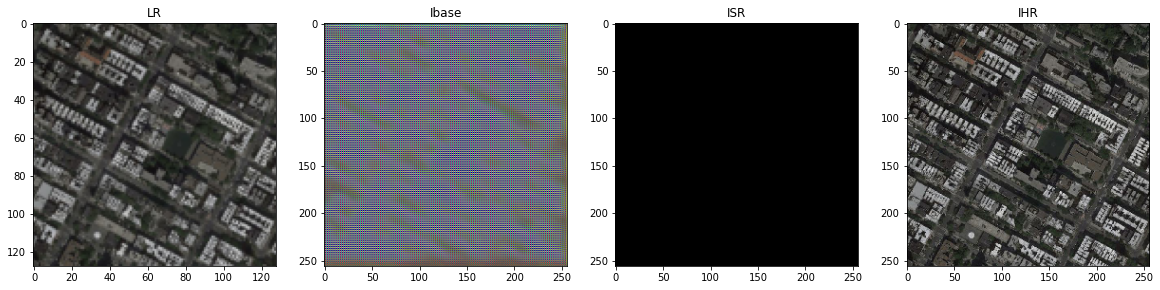

In [318]:
ix=np.random.randint(0, 1096, 1)
ILR=resized_list[ix]
IHR=src_list[ix]
Ibase=udsn(ILR)
ISR=eesn(Ibase)

plt.figure(figsize=(20, 80))

plt.subplot(1,4,1)
ILR=ILR*127.5+127.5
plt.imshow(ILR.reshape(128,128,3).astype('uint8'))
plt.title('LR')

plt.subplot(1,4,2)
Ibase1=Ibase*127.5+127.5
plt.imshow(np.array(Ibase1).reshape(256,256,3).astype('uint8'))
plt.title('Ibase')

plt.subplot(1,4,3)
ISR1=ISR*127.5+127.5
plt.imshow(np.array(ISR).reshape(256,256,3).astype('uint8'))
plt.title('ISR')

plt.subplot(1,4,4)
plt.imshow((IHR*127.5+127.5).reshape(256,256,3).astype('uint8'))
plt.title('IHR')

In [319]:
#vgg(Ibase)

In [320]:
Ibase*127.5+127.5

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[184.84222 , 202.88141 ,  60.610794],
         [ 77.13638 , 154.79645 , 112.57675 ],
         [131.33904 , 111.05112 ,  65.74484 ],
         ...,
         [ 89.71625 ,  86.26015 ,  69.277664],
         [ 76.81874 ,  74.77948 ,  86.18514 ],
         [ 94.65102 , 119.19294 ,  68.99306 ]],

        [[ 74.02768 ,  72.578186, 109.02179 ],
         [ 78.65155 ,  67.128204,  53.55181 ],
         [ 72.23088 , 101.55171 , 172.67818 ],
         ...,
         [ 95.102036, 142.2119  ,  65.995636],
         [ 91.05775 ,  76.06618 , 108.831535],
         [117.703285, 124.87411 ,  87.32803 ]],

        [[197.74596 , 236.67444 ,  45.161934],
         [ 90.30162 , 113.899284, 139.33536 ],
         [125.994995, 238.88605 ,  54.793022],
         ...,
         [179.80563 ,  73.94273 ,  91.352104],
         [ 74.8988  , 123.06834 , 134.41898 ],
         [164.88089 , 108.86946 ,  69.62999 ]],

        ...,

        [[ 91.663574,  97.44119 , 

In [321]:
Ibase.shape

TensorShape([1, 256, 256, 3])